In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_csv('../data/jamb_exam_results.csv')
df.head(2).transpose()

,0,1
JAMB_Score,192,207
Study_Hours_Per_Week,22,14
Attendance_Rate,78,88
Teacher_Quality,4,4
Distance_To_School,12.4,2.7
School_Type,Public,Public
School_Location,Urban,Rural
Extra_Tutorials,Yes,No
Access_To_Learning_Materials,Yes,Yes
Parent_Involvement,High,High


# Preparing the dataset

Preparation:
* df.columns = df.columns.str.lower().str.replace(' ', '_')
* Remove the student_id column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1.
* Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [8]:
del df['student_id']
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [9]:
df.isna().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [10]:
df = df.fillna(0)
df.isna().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   jamb_score                    5000 non-null   int64  
 1   study_hours_per_week          5000 non-null   int64  
 2   attendance_rate               5000 non-null   int64  
 3   teacher_quality               5000 non-null   int64  
 4   distance_to_school            5000 non-null   float64
 5   school_type                   5000 non-null   object 
 6   school_location               5000 non-null   object 
 7   extra_tutorials               5000 non-null   object 
 8   access_to_learning_materials  5000 non-null   object 
 9   parent_involvement            5000 non-null   object 
 10  it_knowledge                  5000 non-null   object 
 11  age                           5000 non-null   int64  
 12  gender                        5000 non-null   object 
 13  soc

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.astype('int').values
y_val = df_val.jamb_score.astype('int').values
y_test = df_test.jamb_score.astype('int').values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [15]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [16]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# Question 1

Let's train a decision tree regressor to predict the jamb_score variable.

* Train a model with max_depth=1.

Which feature is used for splitting the data?

* study_hours_per_week
* attendance_rate
* teacher_quality
* distance_to_school

In [21]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [22]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



# Question 2
Train a random forest regressor with these parameters:

* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12

In [24]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [27]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)


y_pred = rf.predict(X_val)

# Calculamos el RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Redondeamos a 2 decimales para comparar con las opciones
print(f'RMSE: {rmse:.2f}')


RMSE: 42.14


# Question 3
Now let's experiment with the n_estimators parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set random_state to 1.
* Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

* 10
* 25
* 80
* 200

In [32]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
    scores.append((n, rmse))

In [33]:
columns = ['n_estimators', 'rmse']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,rmse
0,10,42.137
1,20,41.461
2,30,41.106
3,40,40.917
4,50,40.852
5,60,40.784
6,70,40.677
7,80,40.539
8,90,40.504
9,100,40.517


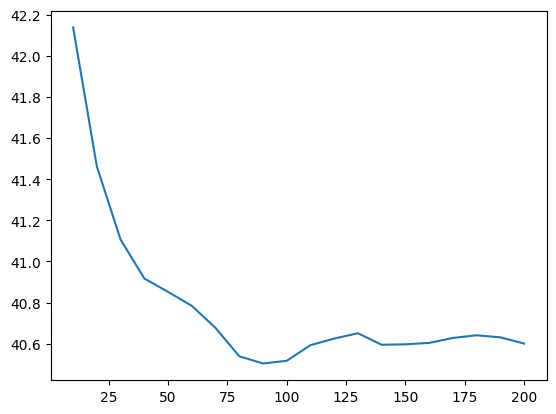

In [34]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

# Question 4
Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25]

For each of these values,
* try different values of n_estimators from 10 till 200 (with step 10)
* calculate the mean RMSE
* Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

* 10
* 15
* 20
* 25

In [39]:
scores = []

for d in [10, 15, 20, 25]: 
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n, 
            max_depth=d,
            random_state=1, 
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n, rmse))
        
    avg_rmse = np.mean(scores[2])
    scores.append((d, avg_rmse))

In [41]:
scores

[(10, 10, np.float64(41.258348648352545)),
 (10, 20, np.float64(40.88052845942386)),
 (10, 30, np.float64(40.62495594199098)),
 (10, 40, np.float64(40.270069249393075)),
 (10, 50, np.float64(40.31700620909737)),
 (10, 60, np.float64(40.27703523312143)),
 (10, 70, np.float64(40.285211180892674)),
 (10, 80, np.float64(40.21030547138022)),
 (10, 90, np.float64(40.17389971253662)),
 (10, 100, np.float64(40.25049014290326)),
 (10, 110, np.float64(40.286316340858086)),
 (10, 120, np.float64(40.31532362946843)),
 (10, 130, np.float64(40.32896060681657)),
 (10, 140, np.float64(40.29975736944223)),
 (10, 150, np.float64(40.314326720921464)),
 (10, 160, np.float64(40.354350211250896)),
 (10, 170, np.float64(40.36008523133161)),
 (10, 180, np.float64(40.36419635538415)),
 (10, 190, np.float64(40.35378105367313)),
 (10, 200, np.float64(40.32501201024062)),
 (10, np.float64(26.87498531399699)),
 (15, 10, np.float64(42.00397868031699)),
 (15, 20, np.float64(41.45569853039702)),
 (15, 30, np.float64(

In [42]:
columns = ['max_depth','n_estimators', 'mean_rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores


,max_depth,n_estimators,mean_rmse
0,10,10.000000,41.258349
1,10,20.000000,40.880528
2,10,30.000000,40.624956
3,10,40.000000,40.270069
4,10,50.000000,40.317006
...,...,...,...
79,25,170.000000,40.624371
80,25,180.000000,40.638564
81,25,190.000000,40.628661
82,25,200.000000,40.598527


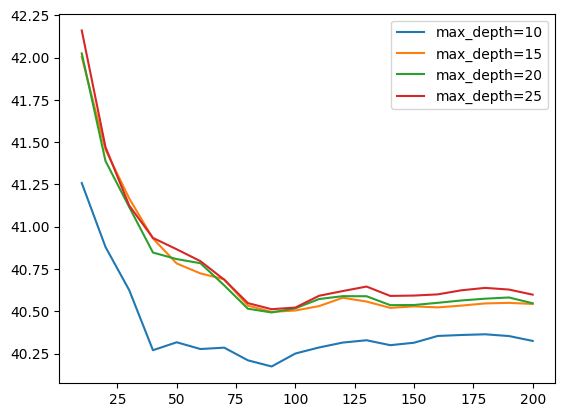

In [44]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.mean_rmse, label='max_depth=%d' % d)

plt.legend()
plt.show()

# Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
* n_estimators=10,
* max_depth=20,
* random_state=1,
* n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature (among these 4)?

* study_hours_per_week
* attendance_rate
* distance_to_school
* teacher_quality

In [45]:
rf = RandomForestRegressor(
            n_estimators=10, 
            max_depth=20,
            random_state=1, 
            n_jobs=-1
        )
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [48]:
all_features = dv.get_feature_names_out()


In [50]:
feature_importance = rf.feature_importances_

importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': feature_importance
})

In [52]:

features_of_interest = [
    'study_hours_per_week',
    'attendance_rate',
    'teacher_quality',
    'distance_to_school']

filtered_importance = importance_df[importance_df['feature'].isin(features_of_interest)]
filtered_importance = filtered_importance.sort_values('importance', ascending=False)


print("Importancia de las características de interés:")
print(filtered_importance.to_string(index=False))


most_important = filtered_importance.iloc[0]['feature']
print(f"\nCaracterística más importante entre las 4: {most_important}")

Importancia de las características de interés:
             feature  importance
study_hours_per_week    0.248354
     attendance_rate    0.149729
  distance_to_school    0.136486
     teacher_quality    0.082682

Característica más importante entre las 4: study_hours_per_week


# Question 6

In [53]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [55]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [56]:
scores = {}

In [63]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'seed':1,
    'verbosity':1,
}


model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=100, 
                  evals=watchlist,
                  verbose_eval=5)

In [64]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [65]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

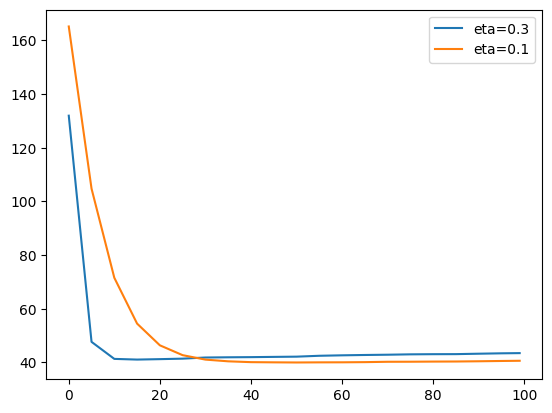

In [68]:

etas = ['eta=0.3', 'eta=0.1']

for eta in etas:
    df_scores = scores[eta]
    plt.plot(df_scores.num_iter, df_scores.val_rmse, label=eta)
    
plt.legend()
plt.show()